In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganGenerator
morgan = GetMorganGenerator(radius=2)
fingerprinter = lambda smiles : np.stack([morgan.GetFingerprintAsNumPy(MolFromSmiles(smile)) for smile in smiles])

import torch
import torch.nn as nn
from models import MLPRegressor, MLPClassifier, RMLPRegressor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_path = '../../data/immunomodulation/log_normalized/regression/'

In [3]:
# Unimol Embeddings
train_X = np.load(data_path + 'train/unimol_embeddings.npy')
validation_X = np.load(data_path + 'validation/unimol_embeddings.npy')
test_X = np.load(data_path + 'test/unimol_embeddings.npy')

In [4]:
train_Y = pd.read_csv(data_path + 'train/y.csv')
validation_Y = pd.read_csv(data_path + 'validation/y.csv')
test_Y = pd.read_csv(data_path + 'test/y.csv')

train_STD = pd.read_csv(data_path + 'train/std.csv')
validation_STD = pd.read_csv(data_path + 'validation/std.csv')
test_STD = pd.read_csv(data_path + 'test/std.csv')

properties = train_Y.columns

In [5]:
# Convert data to Tensors
train_X = torch.tensor(train_X, dtype=torch.float32).detach().to(device)
validation_X = torch.tensor(validation_X, dtype=torch.float32).detach().to(device)
test_X = torch.tensor(test_X, dtype=torch.float32).detach().to(device)

train_Y = torch.tensor(train_Y.to_numpy(), dtype=torch.float32).detach().to(device)
validation_Y = torch.tensor(validation_Y.to_numpy(), dtype=torch.float32).detach().to(device)
test_Y = torch.tensor(test_Y.to_numpy(), dtype=torch.float32).detach().to(device)

train_Var = torch.tensor(train_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2
validation_Var = torch.tensor(validation_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2
test_Var = torch.tensor(test_STD.to_numpy(), dtype=torch.float32).detach().to(device) ** 2

## MLP Model

## Train

 19%|███████▉                                  | 96/512 [00:18<01:18,  5.27it/s]


Val.: 0.0511
Test: 0.0358


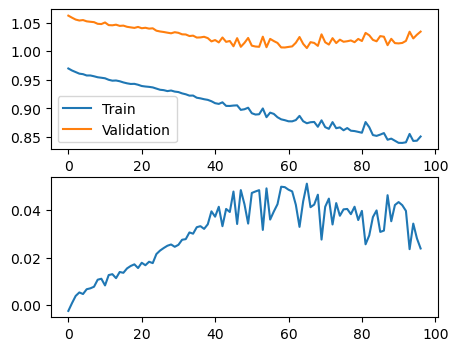

In [6]:
mlp = RMLPRegressor(
    in_features=train_X.shape[1], out_features=train_Y.shape[1], 
    depth=4, width=256, dropout=0.4
).to(device)

validation_score = mlp.fit(
    train_X, train_Y, 
    validation_X, validation_Y, 
    lr=0.00005, epochs=512, batch_size=32, 
    early_stopping=True, plot=True
)
test_score = mlp.score(test_X, test_Y)

print(f'Val.: {validation_score:.4f}')
print(f'Test: {test_score:.4f}')

## Visualization

In [7]:
test_predictions = mlp(test_X).detach()

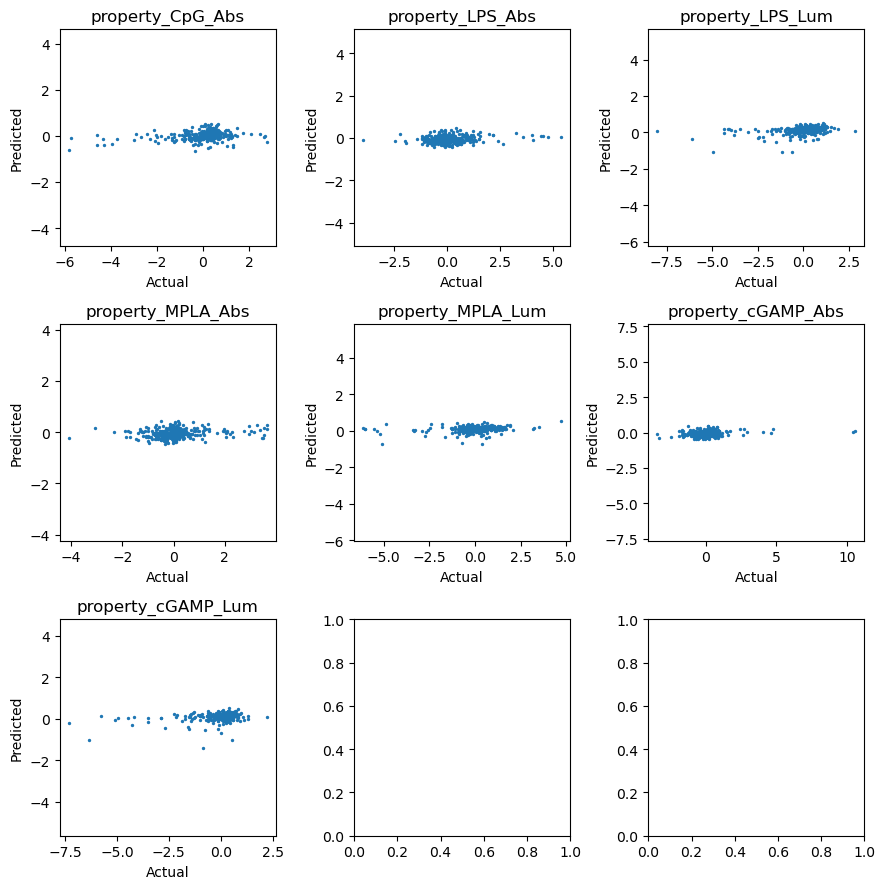

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y[:, i].cpu(), test_predictions[:, i].cpu(), s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()